In [1]:
import pickle
import numpy as np
import pandas as pd
from datetime import datetime
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import keras_tuner as kt
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
with open(r'.\Reviews_Dataset_Splits\X_train.pkl', 'rb') as f:
    X_train = pickle.load(f)

with open(r'.\Reviews_Dataset_Splits\X_val.pkl', 'rb') as f:
    X_val = pickle.load(f)

with open(r'.\Reviews_Dataset_Splits\X_test.pkl', 'rb') as f:
    X_test = pickle.load(f)

with open(r'.\Reviews_Dataset_Splits\y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)

with open(r'.\Reviews_Dataset_Splits\y_val.pkl', 'rb') as f:
    y_val = pickle.load(f)

with open(r'.\Reviews_Dataset_Splits\y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)

y_train = keras.utils.to_categorical(y_train-1, num_classes=5)
y_val = keras.utils.to_categorical(y_val-1, num_classes=5)
y_test = keras.utils.to_categorical(y_test-1, num_classes=5)

with open(r'.\embeddingMatrix_Reviews.pkl', 'rb') as f:
    embedding_matrix = pickle.load(f)

num_tokens = len(embedding_matrix) # total vocabulary +1 or length of embedding matrix
embedding_dim = 300 # dimension of the vector of a single word
MAX_REVIEW_LEN = 250 # maximum words in a review
num_classes = 5

In [3]:
embedding_layer = keras.layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    input_length=MAX_REVIEW_LEN,
    trainable=True,
    mask_zero=True)

model = keras.Sequential()
model.add(embedding_layer)

activation = 'tanh'
kernel_initializer = 'he_uniform'

model.add(layers.LSTM(64, activation=activation, kernel_initializer=kernel_initializer, return_sequences=True))
model.add(layers.BatchNormalization())
model.add(layers.LSTM(128, activation=activation, kernel_initializer=kernel_initializer, return_sequences=True))
model.add(layers.LSTM(64, activation=activation, kernel_initializer=kernel_initializer, return_sequences=False))
model.add(layers.Dense(num_classes, activation='softmax'))

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [4]:
NUM_EPOCHS = 3
BATCH_SIZE = 128
history = model.fit(X_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val))

Epoch 1/3
771/771 [==============================] - 52s 55ms/step - loss: 1.1831 - accuracy: 0.4984 - val_loss: 1.0867 - val_accuracy: 0.5506
Epoch 2/3
771/771 [==============================] - 39s 51ms/step - loss: 0.9099 - accuracy: 0.6385 - val_loss: 1.0482 - val_accuracy: 0.5796
Epoch 3/3
771/771 [==============================] - 39s 51ms/step - loss: 0.6839 - accuracy: 0.7400 - val_loss: 1.1016 - val_accuracy: 0.5916


In [5]:
score = model.evaluate(X_val, y_val, verbose=1)
print("Validation loss: ", score[0])
print("Validation accuracy: ", score[1])

771/771 [==============================] - 11s 14ms/step - loss: 1.1016 - accuracy: 0.5916
Validation loss:  1.1015963554382324
Validation accuracy:  0.5916024446487427


In [6]:
y_prediction = model.predict(X_test)
y_prediction = np.argmax(y_prediction, axis=1)
y_actuals = np.argmax(y_test, axis=1)
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_actuals, y_prediction , normalize='pred')
print(result)

680/680 [==============================] - 12s 14ms/step
[[0.67559125 0.16062661 0.07519001 0.02596491 0.03517488]
 [0.1869701  0.56488193 0.16178067 0.06409357 0.04332273]
 [0.07585899 0.16764087 0.58089034 0.18690058 0.07492051]
 [0.02967425 0.0640636  0.13463626 0.53450292 0.22833863]
 [0.0319054  0.042787   0.04750271 0.18853801 0.61824324]]


In [7]:
accuracy_score = metrics.accuracy_score(y_prediction, y_actuals)

print('RNN accuracy is',str('{:04.2f}'.format(accuracy_score*100))+'%')
print('------------------------------------------------')
print('Confusion Matrix:')
print(pd.DataFrame(confusion_matrix(y_actuals, y_prediction)))
print('------------------------------------------------')
print('Classification Report:')
print(classification_report(y_actuals, y_prediction))

RNN accuracy is 59.68%
------------------------------------------------
Confusion Matrix:
      0     1     2     3     4
0  3028   687   277   111   177
1   838  2416   596   274   218
2   340   717  2140   799   377
3   133   274   496  2285  1149
4   143   183   175   806  3111
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.71      0.69      4280
           1       0.56      0.56      0.56      4342
           2       0.58      0.49      0.53      4373
           3       0.53      0.53      0.53      4337
           4       0.62      0.70      0.66      4418

    accuracy                           0.60     21750
   macro avg       0.59      0.60      0.59     21750
weighted avg       0.59      0.60      0.59     21750



In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

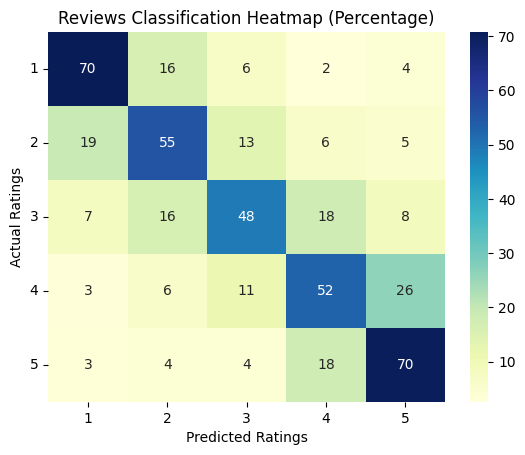

In [9]:
# Create a confusion matrix
confusion_matrix = np.zeros((num_classes, num_classes))
for i in range(len(y_prediction)):
    confusion_matrix[y_actuals[i], y_prediction[i]] += 1

# Normalize the confusion matrix to show percentages
confusion_matrix = 100 * confusion_matrix / confusion_matrix.sum(axis=1, keepdims=True)

lables = [1, 2, 3, 4, 5]
# Create a heatmap with annotation
annot_matrix = np.around(confusion_matrix, 1).astype(int)  # Round percentages to 1 decimal place
ax = sns.heatmap(confusion_matrix, annot=annot_matrix, fmt='d', cmap="YlGnBu", xticklabels=lables, yticklabels=lables)

# Set the title and axis labels
plt.title("Reviews Classification Heatmap (Percentage)")
plt.xlabel("Predicted Ratings")
plt.ylabel("Actual Ratings")

# Rotate the x-axis labels for better visibility
plt.yticks(rotation=0)

# Display the heatmap
plt.show()

In [10]:
from tensorflow.keras.models import load_model
import os

# Save the model
model_save_path = 'SavedModels/RNN_BestModel.h5'
model.save(model_save_path)

In [11]:
# Load the model
loaded_model = load_model(model_save_path)
score2 = loaded_model.evaluate(X_val, y_val, verbose=1)
print("Validation loss: ", score2[0])
print("Validation accuracy: ", score2[1])

771/771 [==============================] - 14s 15ms/step - loss: 1.1016 - accuracy: 0.5916
Validation loss:  1.1015963554382324
Validation accuracy:  0.5916024446487427
